# Demo session of NORDic at JOBIM 2025

Network-centric identification and analysis of a model of post-traumatic stress disorder with NORDic (using Python 3.8, 3.9 or 3.10)

In [1]:
import subprocess as sb
import pandas as pd
from IPython.display import Image, display
import numpy as np
from NORDic.UTILS.utils_plot import plot_influence_graph
from NORDic.NORDic_NI.functions import network_identification

## Installation of NORDic
Using pip (package hosted on PyPI)

Using conda (package hosted on Anaconda.org)

Using CoLoMoTo-Docker (since March 1st, 2023)

From GitHub

To use NORDic, you need access to several databases:

### 1. Registration to DisGeNET (https://www.disgenet.org/signup/)

Click on the link above to sign up to DisGeNET. Once you are registered, open an empty .TXT file, and write down

    on the first line: the e-mail address used for registration
    on the second line: the chosen password
    on the third line: the API key (go to you profile and select the "API key" tab)

Save the file, and replace the relative path to that file in the cell below

In [2]:
DisGeNET_credentials = "credentials_DISGENET.txt"

### 2. Registration to STRING (https://string-db.org)

The STRING database requires an identification of the person sending requests to the database. Write down on the first line of an empty .TXT file your e-mail address, and replace the relative path to that file in the cell below:

In [3]:
STRING_credentials = "credentials_STRING.txt"

### 3. Registration to LINCS L1000/CLUE.io (https://clue.io/connectopedia/?search=L1000)

Click on the link above to sign up to CLUE.io. Once you are registered, open an empty .TXT file, and write down

    on the first line: the e-mail address used for registration
    on the second line: the chosen password
    on the third line: the user key you were assigned Save the file, and replace the relative path to that file in the cell below

In [4]:
LINCS_credentials = "credentials_LINCS.txt"

## Information about PTSD

NORDic can take several kinds of inputs: the MedGen Concept ID linked to a disease, a list of genes of interest, a prior knowledge network or a set of binarized experimental profiles.

### 1. Get the Concept ID of a disease on MedGen

In [5]:
disease_cid = "C0038436" ## but only 2 genes are associated with PTSD on DisGeNet: BDNF, PCDHA4	

### 2. List genes of interest for the disease

In [6]:
# Differentially expressed genes from Daskalakis et al., Science 2024 (DOI: 10.1126/science.adh3707)
# plus some genes for which experiments in the JURKAT cell line in LINCS L1000 exist
gene_list = ["ASAH2", "BSG", "CDKN1A", "COL18A1", "COL4A1", "COL6A3", "COL9A1", "EGLN1", 
             "ENPP7", "GRPEL1", "HGF", "IL6", "LTA", "LTBR", "MMP12", "MMP8", "NFKBIE", 
             "PI3", "POLR2F", "PROC", "PSME2", "SERPINE1", "SMPD1", "TGFB1", "TIMP1", 
             "TNF", "TNFRSF11A", "TNFRSF12A", "TNFRSF1B", "TNFSF13B", 
             "TNFSF14", "VEGFA"] + ["C2", "DECR1", "EZR", "F9", "RNASET2", "TNFRSF9"]
path_to_genes = "gene_list.txt" # save the list of genes
with open(path_to_genes, "w") as f:
    f.write("\n".join(gene_list))
"Number of genes %d" % len(gene_list) ## we choose a small number for the sake of demonstration

'Number of genes 38'

### 3. Generate a prior knowledge network from the literature

In [7]:
# Get a protein-protein interaction network from STRING (https://string-db.org) 
# here with all default parameters but "combined_score" > 0.150
network = pd.read_csv("string_interactions_short_demo.tsv", sep="\t")[["#node1","node2","combined_score"]]
network["directed"] = 0 # no hypothesis on the direction
network["sign"] = 2 # no hypothesis on the sign
network = network[["#node1","node2","combined_score", "directed", "sign"]]
network = network[["#node1","node2", "sign", "directed", "combined_score"]]
network.columns = ["preferredName_A", "preferredName_B", "sign", "directed", "score"]
network_fname = "network.tsv" ## save the network
network.to_csv(network_fname, sep="\t", index=None)
network = pd.read_csv(network_fname, sep="\t")
network

,preferredName_A,preferredName_B,sign,directed,score
0,ASAH2,ENPP7,2,0,0.888
1,ASAH2,SMPD1,2,0,0.882
2,ASAH2,TNF,2,0,0.177
3,BSG,TIMP1,2,0,0.469
4,BSG,TGFB1,2,0,0.392
...,...,...,...,...,...
242,TNFRSF1B,TNFRSF9,2,0,0.640
243,TNFRSF1B,TNFSF14,2,0,0.713
244,TNFRSF9,TNFSF13B,2,0,0.573
245,TNFRSF9,TNFSF14,2,0,0.683


/home/fabien.romano/miniconda3/envs/env/lib/python3.10/site-packages/NORDic/UTILS/utils_plot.py:94: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  influences = pd.concat((influences, pd.DataFrame([], index=influences.index, columns=missing_cols).fillna(0)), axis=1)
/home/fabien.romano/miniconda3/envs/env/lib/python3.10/site-packages/NORDic/UTILS/utils_plot.py:96: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  influences = pd.concat((influences, pd.DataFrame([], index=missing_idxs, columns=influences.columns).fillna(0)), axis=0)


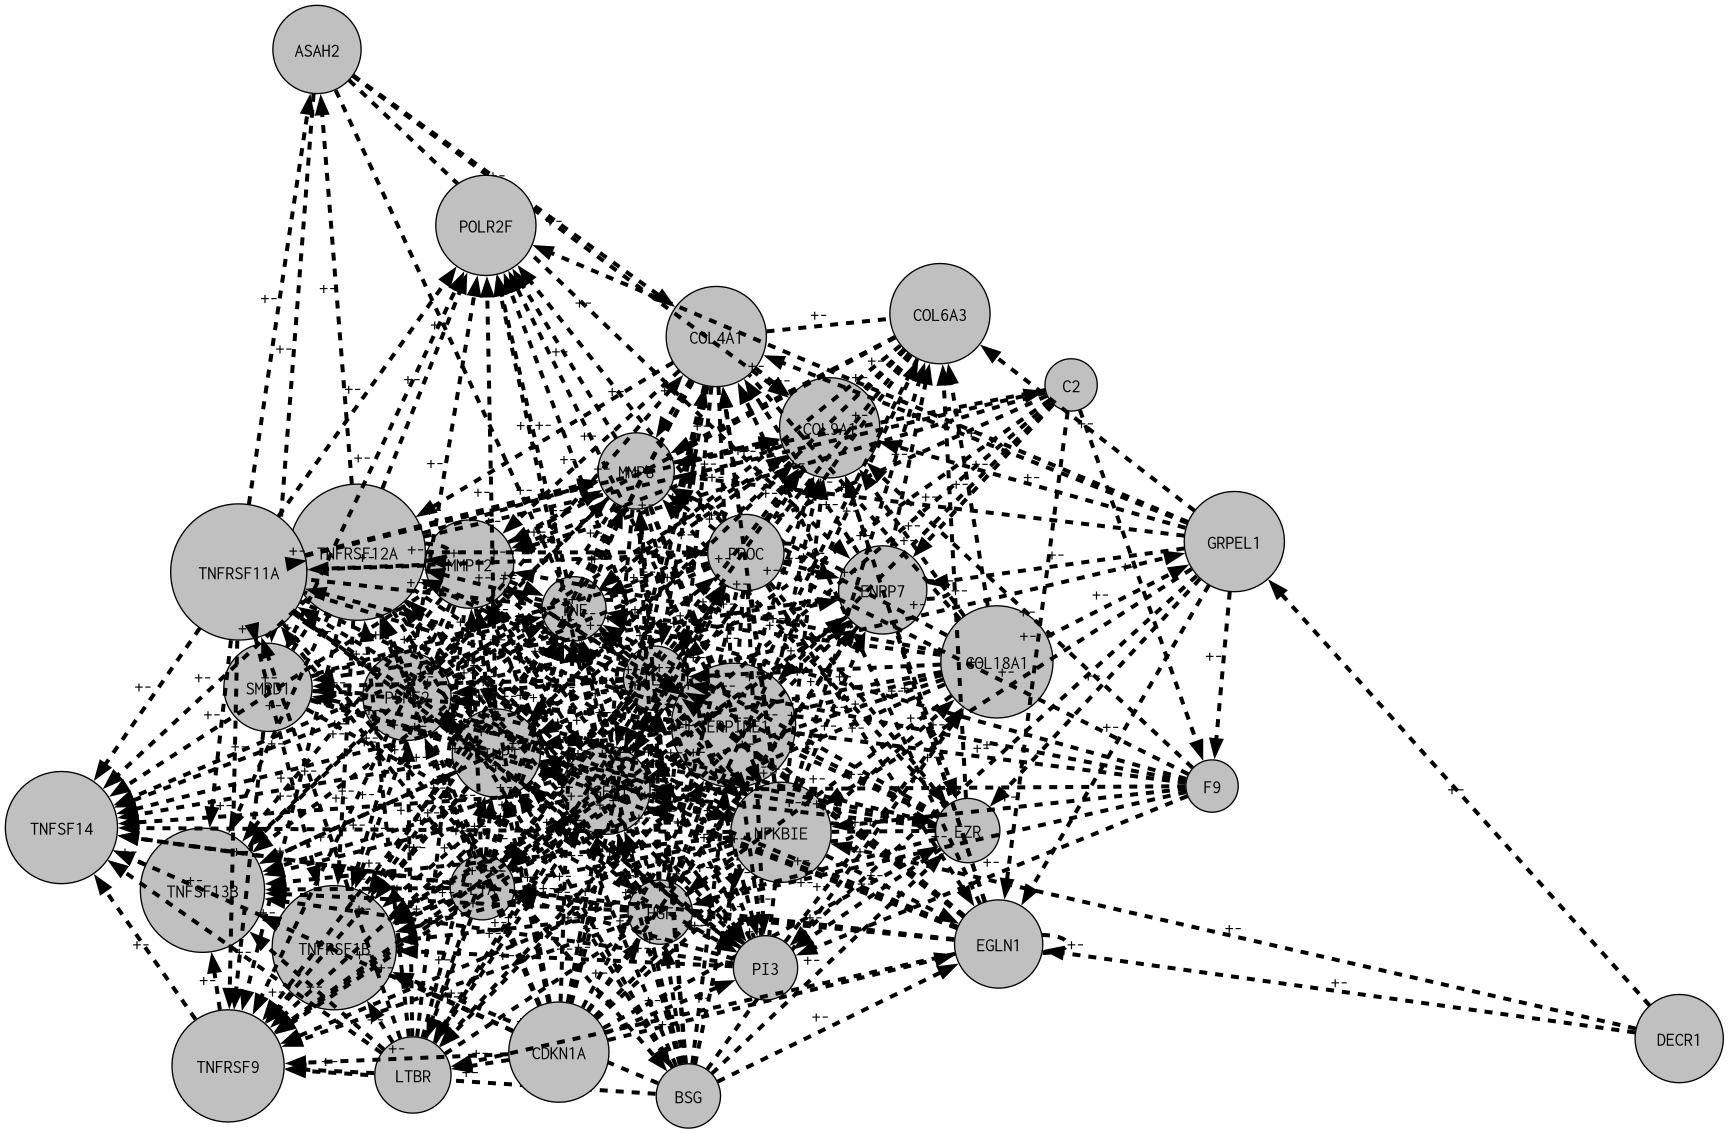

In [8]:
plot_influence_graph(network, "preferredName_A", "preferredName_B", "sign", direction_col="directed", fname="prior_graph", optional=True)
display(Image('prior_graph.png', width=500))

### 4. Get a set of relevant binarized experimental profiles

For the sake of simplicity, we will use profiles from the LINCS L1000 database. We defer the presentation of this case to the end of the notebook.

## NORDic NI: Network Identification

The objective is to obtain a Boolean model (including dynamics) on PTSD. We present the three main approaches based on the input provided (gene list, or prior knowledge network).

### 1. Parameters to NORDic NI

In [9]:
## Registration to databases
DisGeNET_credentials = "credentials_DISGENET.txt"
STRING_credentials = "credentials_STRING.txt"
LINCS_credentials = "credentials_LINCS.txt"
## Parameters
seed_number=123456
from multiprocessing import cpu_count
njobs=1 ## considering only one
file_folder="./"
taxon_id=9606 # human species
disease_cids=[disease_cid] ## Concept ID of studied syndrome
cell_lines=["JURKAT"] # blood cell line in LINCS L1000
## Information about the disease
DISGENET_args = {
        "credentials": DisGeNET_credentials, "disease_cids": disease_cids,
}
## Selection of parameters relative to the prior knowledge network 
STRING_args = {
        "credentials": STRING_credentials, "score": 0,
}
EDGE_args = {
        "tau": 0, "filter": True, "connected": True, 
}
accept_nonRNA=True
preserve_network_sign=True
## Selection of parameters relative to experimental constraints
LINCS_args = {
        "path_to_lincs": "../lincs/", "credentials": LINCS_credentials,
        "cell_lines": cell_lines, "thres_iscale": None, "pert_types" : ["trt_sh"]
}
SIG_args = {
        "bin_thres": 0.5,
}
force_experiments=False
## Selection of parameters relative to the inference of networks
BONESIS_args = {
        "limit": 1, "exact": False, "max_maxclause": 3,
}
## Advanced
DESIRABILITY = {"DS": 3, "CL": 3, "Centr": 3, "GT": 1}

Most of these parameters can be left by default, however a few of them need to be finetuned carefully:

In [10]:
## Important parameters to finetune
STRING_args.update({"score": 0}) # threshold on edge confidence score: tradeoff computational cost-biological relevance
EDGE_args.update({"tau": 0}) # threshold on co-expression to filter out edges: tradeoff computational cost-feasability
SIG_args.update({"bin_thres": 0.5}) # binarization threshold for the experiments: tradeoff feasability-biological relevance
BONESIS_args.update({"limit": 1}) # number of networks to generate

### 2. Giving as input the gene list

In that case, NORDic retrieves automatically a protein-protein interaction network from STRING involving genes in the input list. 

In [11]:
# Finetuned parameters
STRING_args.update({"score": 0}) 
EDGE_args.update({"tau": 0}) 
SIG_args.update({"bin_thres": 0.40}) # 0.25, 0.4: solution | 0.405, 0.41, 0.42, 0.425, 0.45, 0.5: no solution
BONESIS_args.update({"limit": 100}) # generate a set of diverse solution networks to select from 

In [12]:
boolnet = network_identification(file_folder+"/only_genes/", taxon_id, 
            path_to_genes=path_to_genes, 
            network_fname=None, ## not provided
            experiments_fname=None, ## not provided
            disgenet_args=DISGENET_args, 
            string_args=STRING_args, lincs_args=LINCS_args, edge_args=EDGE_args,
            sig_args=SIG_args, bonesis_args=BONESIS_args, weights=DESIRABILITY,
            seed=seed_number, njobs=njobs, force_experiments=force_experiments)

100 solutions are already generated, and saved at .//only_genes/SOLUTIONS-100_binthres=0.400_thresiscale=None_score=0.00_maxclause=3_{1,...1}.zip
--- SELECTION OF OPTIMAL MODEL ---
A. Select an optimal model based on a topological criteria...  ...100 solutions (100 unique solutions)
... 100 solutions (9/35 constant genes in average)
<MODEL VISUALIZATION> Minimal solution: 20 edges
<MODEL VISUALIZATION> Maximal solution: 46 edges
          1         2         3         4         5         6         7    \
GTP  0.862436  0.843947  0.831066  0.818997  0.814497  0.830867  0.829651   

          8         9         10        11        12        13        14   \
GTP  0.837421  0.815692  0.844655  0.847197  0.820345  0.821837  0.831966   

         15        16       17        18        19        20        21   \
GTP  0.83018  0.826412  0.82318  0.820449  0.821609  0.817705  0.835934   

         22       23        24        25        26        27        28   \
GTP  0.84552  0.83101  0.829909

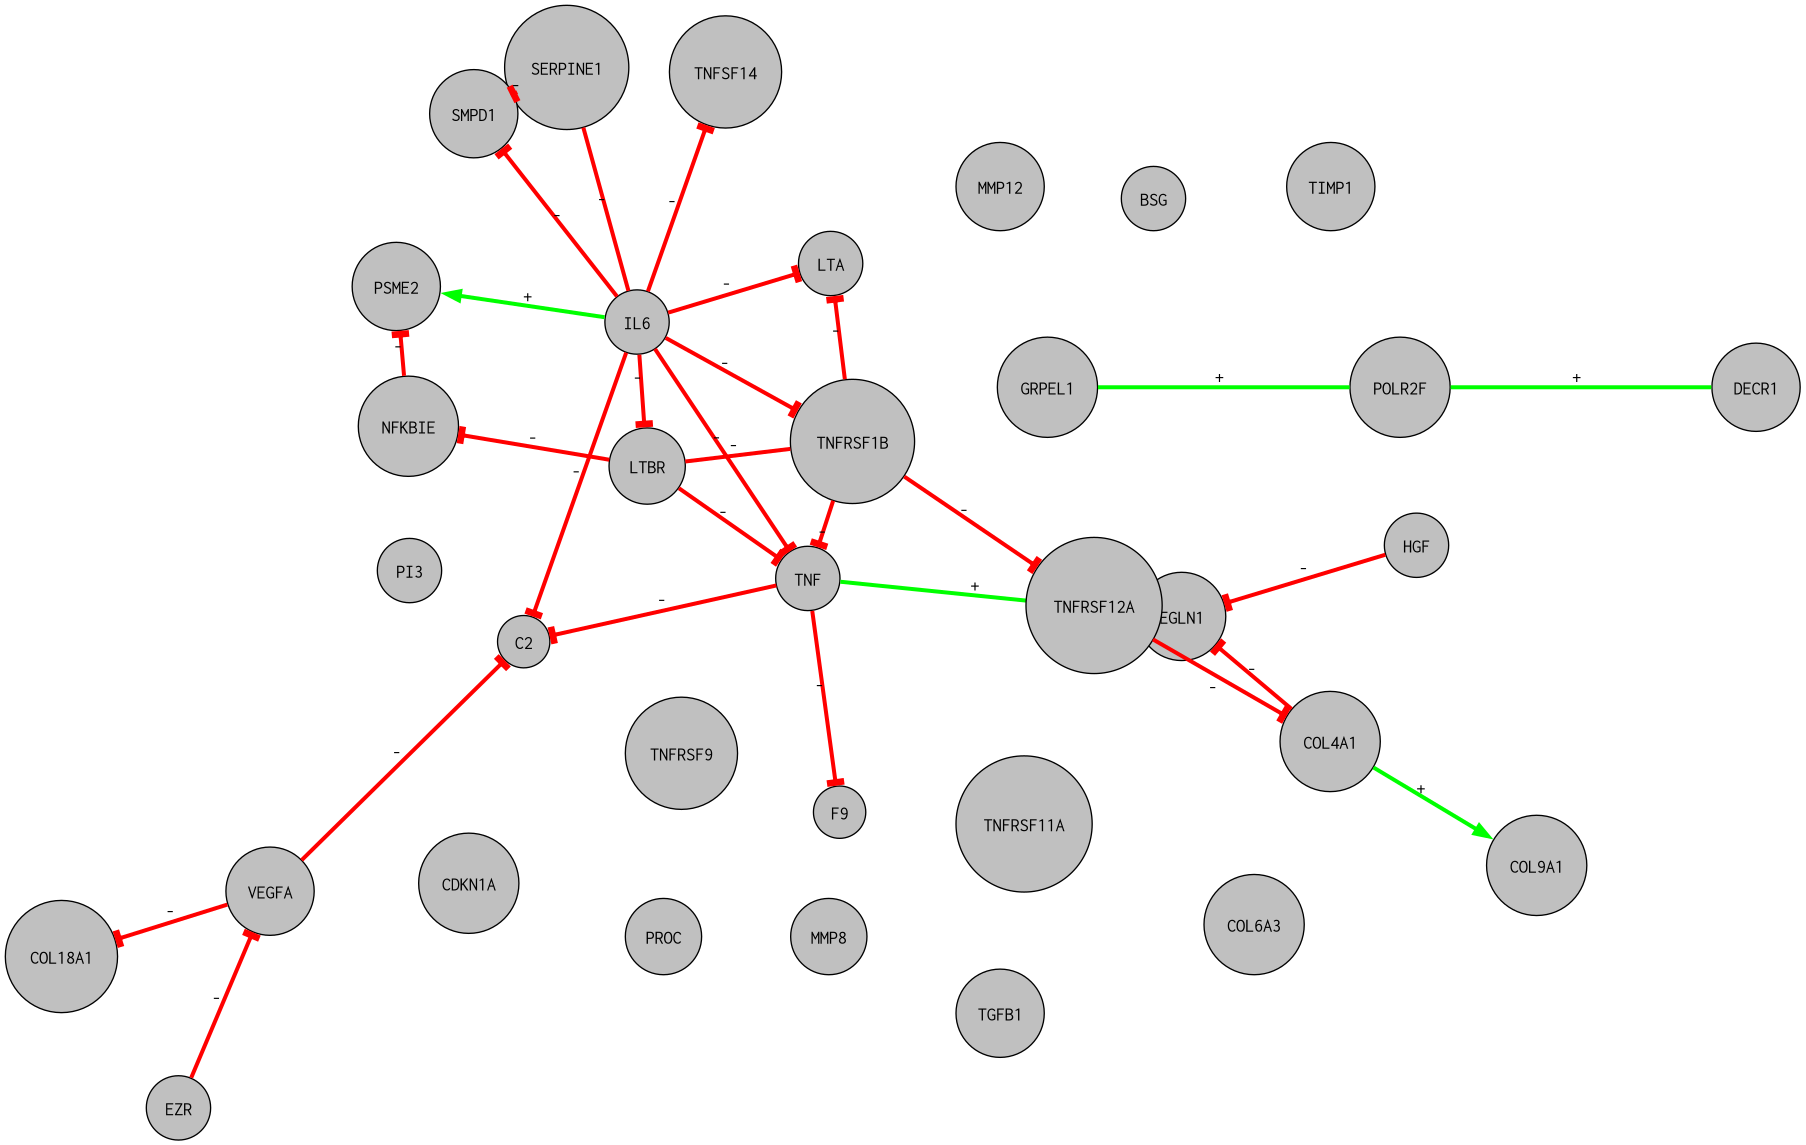

In [13]:
from IPython.display import Image
display(Image(file_folder+"/only_genes/"+'inferred_max_criterion_solution.png', width=500))

### 3. Giving as input the prior knowledge network 

This overrides giving the list of genes. NORDic will rely on this graph to infer Boolean networks.

In [14]:
# Finetuned parameters
STRING_args.update({"score": 0}) 
EDGE_args.update({"tau": 0}) 
SIG_args.update({"bin_thres": 0.30}) # 0.25, 0.3: solution | 0.305, 0.31, 0.32, 0.35, 0.40: no solution
BONESIS_args.update({"limit": 100}) 

In [15]:
boolnet_net = network_identification(file_folder+"/only_network/", taxon_id, 
            path_to_genes=None, ## not provided
            network_fname=network_fname,
            experiments_fname=None, ## not provided
            disgenet_args=DISGENET_args, 
            string_args=STRING_args, lincs_args=LINCS_args, edge_args=EDGE_args,
            sig_args=SIG_args, bonesis_args=BONESIS_args, weights=DESIRABILITY,
            seed=seed_number, njobs=njobs, force_experiments=force_experiments)

--- DATA IMPORT ---
1. Import gene set from DisGeNET... ... 36 genes imported.
2. Import network from network.tsv... ... 247 edges in model (including 0 directed edges) with a total of 36 non-isolated genes
3. Import experiments from LINCS L1000... 
	1 cell lines are considered (['JURKAT'])
<UTILS_DATA> Gene Symbol -> Gene ID (36 probes)
<BioDBNet> 1/1
36 probes (successful 36, unsuccessful 0)
	36 genes available (convertable to EntrezIDs)
<UTILS_DATA> Entrez ID -> LINCS L1000 (1/36)
56624	ASAH2	1	36
<UTILS_DATA> Entrez ID -> LINCS L1000 (2/36)
682	BSG	2	36
<UTILS_DATA> Entrez ID -> LINCS L1000 (3/36)
3183; 717	C2	3	36
<UTILS_DATA> Entrez ID -> LINCS L1000 (4/36)
150383; 1026	CDKN1A	4	36
<UTILS_DATA> Entrez ID -> LINCS L1000 (5/36)
80781	COL18A1	5	36
<UTILS_DATA> Entrez ID -> LINCS L1000 (6/36)
1282	COL4A1	6	36
<UTILS_DATA> Entrez ID -> LINCS L1000 (7/36)
1293	COL6A3	7	36
<UTILS_DATA> Entrez ID -> LINCS L1000 (8/36)
1297	COL9A1	8	36
<UTILS_DATA> Entrez ID -> LINCS L1000 (9/36)
1666	DEC

/home/fabien.romano/miniconda3/envs/env/lib/python3.10/site-packages/cmapPy/pandasGEXpress/parse_gctx.py:275: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  meta_df = meta_df.apply(lambda x: pd.to_numeric(x, errors="ignore"))
/home/fabien.romano/miniconda3/envs/env/lib/python3.10/site-packages/cmapPy/pandasGEXpress/parse_gctx.py:275: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  meta_df = meta_df.apply(lambda x: pd.to_numeric(x, errors="ignore"))


<INTERFERENCE SCALE> KD Perturbed 1666 = 0.80424 || Most stable control 1915 = 1.00029
<INTERFERENCE SCALE> 0.19600
... 32 genes, 5 profiles
<UTILS_EXP> 1 experiments so far
	<UTILS_EXP> Treatment EZR (entrez_id 7430)... <BioDBNet> 1/1
<LINCS> 5 TREATED experiments ('brew_prefix') (3 profiles 'distil_id' in average)
<LINCS> Selected distil_ss = 5.361789703369141
<LINCS> 3 same-plate profiles
<LINCS> 15 CONTROL experiments ('brew_prefix') (4 profiles 'distil_id' in average)
<LINCS> Selected distil_ss = 3.963320732116699
<LINCS> 3 same-plate profiles


/home/fabien.romano/miniconda3/envs/env/lib/python3.10/site-packages/cmapPy/pandasGEXpress/parse_gctx.py:275: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  meta_df = meta_df.apply(lambda x: pd.to_numeric(x, errors="ignore"))
/home/fabien.romano/miniconda3/envs/env/lib/python3.10/site-packages/cmapPy/pandasGEXpress/parse_gctx.py:275: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  meta_df = meta_df.apply(lambda x: pd.to_numeric(x, errors="ignore"))


<INTERFERENCE SCALE> KD Perturbed 7430 = 0.93913 || Most stable control 2597 = 0.97012
<INTERFERENCE SCALE> 0.03194
... 32 genes, 6 profiles
<UTILS_EXP> 2 experiments so far
	<UTILS_EXP> Duplicated treatment:EZR, cell:JURKAT, type:trt_sh
<UTILS_EXP> 2 experiments so far
	<UTILS_EXP> Duplicated treatment:EZR, cell:JURKAT, type:trt_sh
<UTILS_EXP> 2 experiments so far
	<UTILS_EXP> Duplicated treatment:EZR, cell:JURKAT, type:trt_sh
<UTILS_EXP> 2 experiments so far
	<UTILS_EXP> Duplicated treatment:EZR, cell:JURKAT, type:trt_sh
<UTILS_EXP> 2 experiments so far
	<UTILS_EXP> Treatment TNFRSF9 (entrez_id 3604)... <BioDBNet> 1/1
<LINCS> 5 TREATED experiments ('brew_prefix') (3 profiles 'distil_id' in average)
<LINCS> Selected distil_ss = 5.9326090812683105
<LINCS> 3 same-plate profiles
<LINCS> 15 CONTROL experiments ('brew_prefix') (4 profiles 'distil_id' in average)
<LINCS> Selected distil_ss = 3.963320732116699
<LINCS> 3 same-plate profiles


/home/fabien.romano/miniconda3/envs/env/lib/python3.10/site-packages/cmapPy/pandasGEXpress/parse_gctx.py:275: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  meta_df = meta_df.apply(lambda x: pd.to_numeric(x, errors="ignore"))
/home/fabien.romano/miniconda3/envs/env/lib/python3.10/site-packages/cmapPy/pandasGEXpress/parse_gctx.py:275: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  meta_df = meta_df.apply(lambda x: pd.to_numeric(x, errors="ignore"))


<INTERFERENCE SCALE> KD Perturbed 3604 = 0.89961 || Most stable control 2597 = 1.00000
<INTERFERENCE SCALE> 0.10039
... 32 genes, 6 profiles
<UTILS_EXP> 3 experiments so far
	<UTILS_EXP> Duplicated treatment:TNFRSF9, cell:JURKAT, type:trt_sh
<UTILS_EXP> 3 experiments so far
	<UTILS_EXP> Duplicated treatment:TNFRSF9, cell:JURKAT, type:trt_sh
<UTILS_EXP> 3 experiments so far
	<UTILS_EXP> Duplicated treatment:TNFRSF9, cell:JURKAT, type:trt_sh
<UTILS_EXP> 3 experiments so far
	<UTILS_EXP> Duplicated treatment:TNFRSF9, cell:JURKAT, type:trt_sh
		3 unique experiments (including 3 with criterion thres_iscale > None, min_value None)
... 33 genes in 17 profiles (3 experiments)

--- CONSTRAINT BUILDING ---
1. Filtering out edges by minimum set of edges with highest score which preserve connectivity... ... 224 unique edges involving genes both in experiments (33 genes in total)


/home/fabien.romano/miniconda3/envs/env/lib/python3.10/site-packages/NORDic/UTILS/utils_plot.py:94: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  influences = pd.concat((influences, pd.DataFrame([], index=influences.index, columns=missing_cols).fillna(0)), axis=1)
/home/fabien.romano/miniconda3/envs/env/lib/python3.10/site-packages/NORDic/UTILS/utils_plot.py:96: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  influences = pd.concat((influences, pd.DataFrame([], index=missing_idxs, columns=influences.columns).fillna(0)), axis=0)


... score_STRING 0.000000	33 genes (non isolated in PPI)	896 edges in PPI
2. Build topological constraints from filtered edges using gene expression data...  ...... 0 negative, 448 positive undirected interactions (448 edges in total), 33 non isolated genes in experiments


/home/fabien.romano/miniconda3/envs/env/lib/python3.10/site-packages/NORDic/UTILS/utils_plot.py:96: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  influences = pd.concat((influences, pd.DataFrame([], index=missing_idxs, columns=influences.columns).fillna(0)), axis=0)


3. Build dynamical constraints by binarization of experimental profiles...  ...<UTILS_EXP> Cell JURKAT (1/1)... <UTILS_EXP> 191 (good) profiles | 50 (best) profiles (capped at 50 or min>=4) (distil_ss max=5.933, min=2.223)


/home/fabien.romano/miniconda3/envs/env/lib/python3.10/site-packages/cmapPy/pandasGEXpress/parse_gctx.py:275: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  meta_df = meta_df.apply(lambda x: pd.to_numeric(x, errors="ignore"))
/home/fabien.romano/miniconda3/envs/env/lib/python3.10/site-packages/cmapPy/pandasGEXpress/parse_gctx.py:275: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  meta_df = meta_df.apply(lambda x: pd.to_numeric(x, errors="ignore"))
/home/fabien.romano/miniconda3/envs/env/lib/python3.10/site-packages/qnorm/quantile_normalize.py:89: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 6.69352543 10.98057193  9.6746789   6.08729231  5.72762589 12.94896035
  8.74885275  5.83370129

... 3 experiments on 1 cell lines and 33/33 genes (Frobenius norm signature matrix: 6.481, 21 possibly constant genes: 63.6%, 8 genes with undetermined status

--- INFER BOOLEAN NETWORK ---
1. Generate solutions from topological & dynamical constraints...  ...<UTILS_GRN> Maximum possible #activators=29
<BONESIS> 448 interactions (maximum # of clauses = 3)

<UTILS_GRN> 3 experiments
           PSME2 MMP12 COL4A1 TNFRSF9 COL6A3 DECR1 COL18A1 POLR2F TIMP1 SMPD1  \
Exp1_init      1     0      0       0      0     1                              
Exp2_init      1     0      0              0     0                              
Exp2_final     1                           0     0              1               
Exp3_init      1     0      0              0     1                              
Exp3_final     1                    0                                 1     0   
Exp1_final                  1       0      0             0      0     1     0   

           MMP8 LTA TNFRSF12A TGFB1 PI3 C2 TNF 

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Grounding...done in 0.5s
Found 100 solutions in 7.1s (first in 0.5s; rate 0.1s)

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.66s/it]

--- SELECTION OF OPTIMAL MODEL ---
A. Select an optimal model based on a topological criteria...  ...

100 solutions (100 unique solutions)
... 100 solutions (13/34 constant genes in average)
<MODEL VISUALIZATION> Minimal solution: 8 edges
<MODEL VISUALIZATION> Maximal solution: 34 edges
          1         2         3         4         5         6         7    \
GTP  0.805016  0.798152  0.820447  0.818585  0.806991  0.796961  0.834709   

          8         9         10        11        12        13        14   \
GTP  0.806293  0.817694  0.814336  0.831115  0.832147  0.818717  0.828663   

         15        16       17        18        19       20        21   \
GTP  0.81854  0.826174  0.81134  0.825071  0.811873  0.79706  0.819615   

          22       23        24        25        26        27        28   \
GTP  0.818942  0.86417  0.839713  0.835504  0.816383  0.816918  0.828696   

          29        30        31        32        33        34        35   \
GTP  0.821334  0.815451  0.835127  0.821553  0.831509  0.824473  0.827924   

          36        37        38        39     

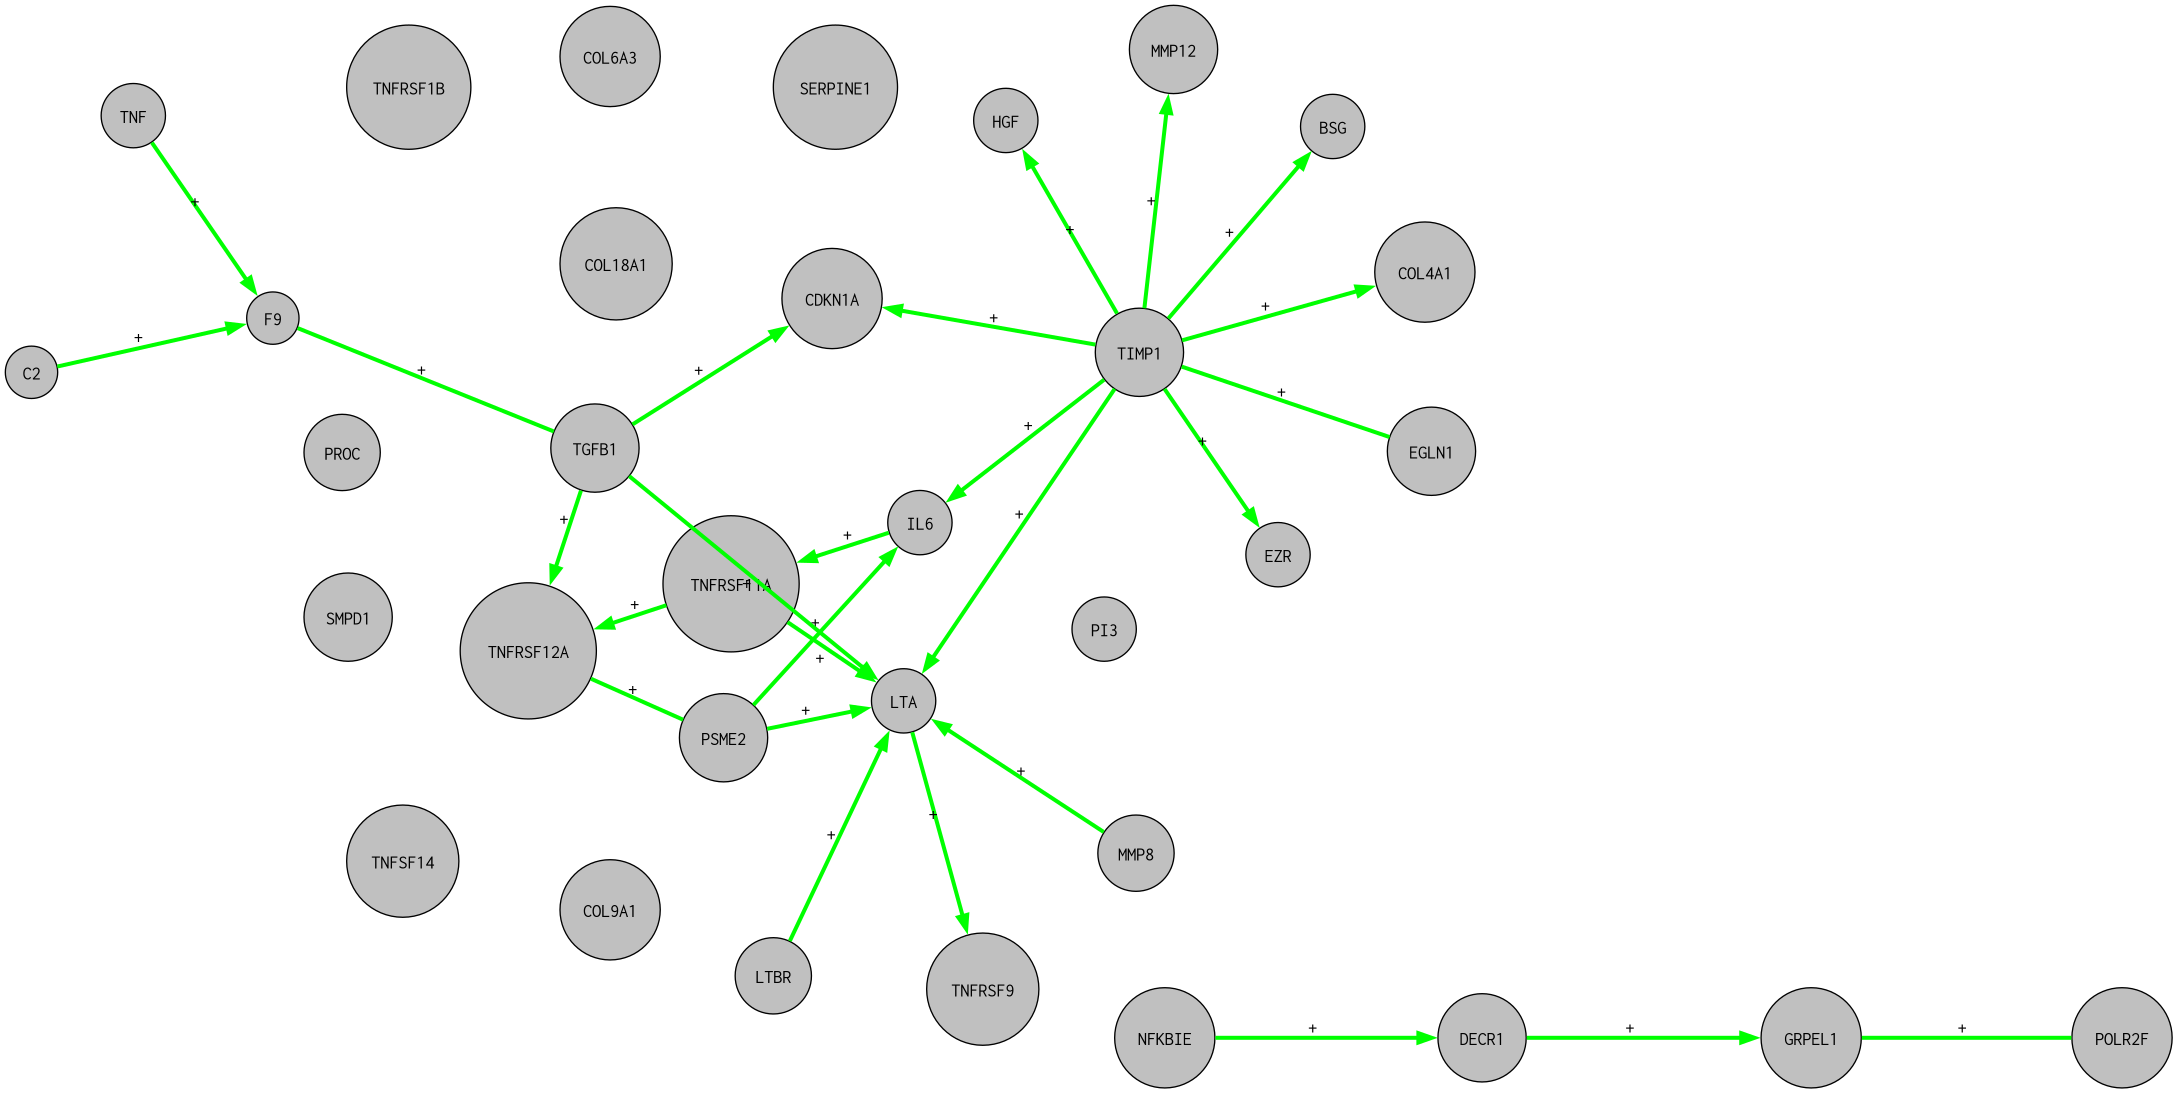

In [16]:
from IPython.display import Image
display(Image(file_folder+"/only_network/"+'inferred_max_criterion_solution.png', width=500))

### 4. Using a set of binarized experimental profiles

We will leverage the fact that NORDic provides intermediary files which can be inspected (and reused) to consider the binarized experiments file produced in the previous runs of NORDic NI. Of course, a custom file (as long as it fits with the formatting constraints) can be used.

NORDic will require in that case (in order to know which prior knowledge network to generate or use) the Concept ID of the disease, a gene list or a prior knowledge network. Let's use the prior knowledge network.

#### 4.a. Create the experimental file

In [17]:
sig_file=file_folder+"only_genes/SIGNATURES_JURKAT_binthres=0.4_thres_iscale=None.csv"
experiments = pd.read_csv(sig_file, sep=",", index_col=0)
experiments[experiments==0] = "0"
experiments[experiments==1] = "1" # for the binarization

/tmp/ipykernel_26887/918157030.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  experiments[experiments==0] = "0"


In [18]:
# whether it is a control (1) or a treated profile (2)
experiments.loc["annotation"] = ["2" if ("_KD_" in c) else "1" for c in experiments.columns] 
# which gene is perturbed (if no perturbation, then None)
experiments.loc["perturbed"] = [c.split("_")[0] if ("initial_" not in c) else "None" for c in experiments.columns] 
# gene perturbation type: KD (knockdown or knockout/trt_sh or trt_xpr in LINCS L1000) or OE (overexpression/trt_oe) or None
experiments.loc["perturbation"] = [c.split("_")[1] if ("initial_" not in c) else "None" for c in experiments.columns] 
# cell line
experiments.loc["cell_line"] = "JURKAT"
experiments.loc["sigid"] = list(experiments.columns)
EXPERIMENTS_fname = file_folder+"experiments.csv"
experiments.to_csv(EXPERIMENTS_fname, sep=",")
profiles = pd.read_csv(EXPERIMENTS_fname, sep=",", index_col=0, keep_default_na=False)
profiles[profiles==""] = np.nan
profiles.head()

,EZR_KD_JURKAT,TNFRSF9_KD_JURKAT,DECR1_KD_JURKAT,initial_JURKAT
NFKBIE,NaN,NaN,0,0
LTA,0,0,1,NaN
LTBR,0,0,NaN,NaN
TNF,0,0,0,0
VEGFA,1,1,1,1


In [19]:
profiles.tail()

,EZR_KD_JURKAT,TNFRSF9_KD_JURKAT,DECR1_KD_JURKAT,initial_JURKAT
annotation,2,2,2,1
perturbed,EZR,TNFRSF9,DECR1,None
perturbation,KD,KD,KD,None
cell_line,JURKAT,JURKAT,JURKAT,JURKAT
sigid,EZR_KD_JURKAT,TNFRSF9_KD_JURKAT,DECR1_KD_JURKAT,initial_JURKAT


#### 4.b. Recover the directed and signed network from before

We can also let NORDic sign the edges but then, since the procedure relies on co-expression computed on experiments, the fact that the experiments are binarized might have a non-negligeable impact on the resulting network.

In [20]:
# Get the graph computed by NORDic on the list of genes
# This file contains an adjacency matrix
adj_matrix = pd.read_csv(file_folder+"only_genes/"+"INFLUENCES_JURKAT_tau=0_beta=1_score_thres=0.csv", sep=",", index_col=0)
network = pd.DataFrame([], index=[], columns=["preferredName_A", "preferredName_B", "sign", "directed", "score"])
for ii, [i,j] in enumerate(np.argwhere(adj_matrix.values!=0).tolist()):
    network.loc[ii] = [adj_matrix.index[i], adj_matrix.index[j], int(adj_matrix.values[i,j]), 1, 1.]

network_exp_fname = "network_exp.tsv" ## save the network
network.to_csv(network_exp_fname, sep="\t", index=None)
network = pd.read_csv(network_exp_fname, sep="\t")
network

,preferredName_A,preferredName_B,sign,directed,score
0,BSG,COL18A1,-1,1,1.0
1,BSG,EZR,-1,1,1.0
2,BSG,HGF,-1,1,1.0
3,BSG,IL6,-1,1,1.0
4,BSG,MMP12,1,1,1.0
...,...,...,...,...,...
403,VEGFA,TNFRSF11A,1,1,1.0
404,VEGFA,TNFRSF12A,-1,1,1.0
405,VEGFA,TNFRSF1B,1,1,1.0
406,VEGFA,TNFRSF9,1,1,1.0


In [21]:
# Finetuned parameters
STRING_args.update({"score": 0}) 
EDGE_args.update({"tau": 0}) 
SIG_args.update({"bin_thres": 0.4}) 
BONESIS_args.update({"limit": 100}) 

In [22]:
boolnet_exp = network_identification(file_folder+"/only_experiments/", taxon_id, 
            path_to_genes=None,  
            network_fname=network_exp_fname, 
            experiments_fname=EXPERIMENTS_fname,
            disgenet_args=DISGENET_args, 
            string_args=STRING_args, lincs_args=LINCS_args, edge_args=EDGE_args,
            sig_args=SIG_args, bonesis_args=BONESIS_args, weights=DESIRABILITY,
            seed=seed_number, njobs=njobs, force_experiments=force_experiments)

--- DATA IMPORT ---
1. Import gene set from DisGeNET... ... 34 genes imported.
2. Import network from network_exp.tsv... ... 408 edges in model (including 408 directed edges) with a total of 34 non-isolated genes
3. Import experiments from ./experiments.csv... 
	1 cell lines are considered (['JURKAT'])
... 34 genes in 4 profiles (4 experiments)

--- CONSTRAINT BUILDING ---
1. Filtering out edges by minimum set of edges with highest score which preserve connectivity... ... 408 unique edges involving genes both in experiments (34 genes in total)


/home/fabien.romano/miniconda3/envs/env/lib/python3.10/site-packages/NORDic/UTILS/utils_plot.py:96: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  influences = pd.concat((influences, pd.DataFrame([], index=missing_idxs, columns=influences.columns).fillna(0)), axis=0)


... score_STRING 0.000000	34 genes (non isolated in PPI)	408 edges in PPI
2. Build topological constraints from filtered edges using gene expression data...  ...... 212 negative, 196 positive undirected interactions (408 edges in total), 34 non isolated genes in experiments


/home/fabien.romano/miniconda3/envs/env/lib/python3.10/site-packages/NORDic/UTILS/utils_plot.py:96: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  influences = pd.concat((influences, pd.DataFrame([], index=missing_idxs, columns=influences.columns).fillna(0)), axis=0)


3. Build dynamical constraints by binarization of experimental profiles...  ...

/home/fabien.romano/miniconda3/envs/env/lib/python3.10/site-packages/NORDic/UTILS/utils_grn.py:500: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  print_exps[print_exps==-1] = ""


... 3 experiments on 1 cell lines and 34/34 genes (Frobenius norm signature matrix: 9.592, 20 possibly constant genes: 58.8%, 0 genes with undetermined status

--- INFER BOOLEAN NETWORK ---
1. Generate solutions from topological & dynamical constraints...  ...<UTILS_GRN> Maximum possible #activators=14
<BONESIS> 408 interactions (maximum # of clauses = 3)

<UTILS_GRN> 3 experiments
           COL18A1 TNFSF14 PSME2 TIMP1  SMPD1 MMP12 TNFRSF1B COL4A1 SERPINE1  \
Exp1_init        1       0     1     0      1     0        0      0        0   
Exp1_final       0       1     0     1      0                     1            
Exp2_init        1       0     1     0      1     0        0      0        0   
Exp3_init        1       0     1     0      1     0        0      0        0   
Exp3_final               0           1      0              0               0   
Exp2_final                     1            0     1        0      0            

           NFKBIE  BSG  COL6A3  TNFRSF9  C2 DECR1  VEG

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Grounding...done in 0.4s
Found 100 solutions in 6.6s (first in 0.4s; rate 0.1s)

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.06s/it]

--- SELECTION OF OPTIMAL MODEL ---
A. Select an optimal model based on a topological criteria...  ...

100 solutions (100 unique solutions)
... 100 solutions (9/35 constant genes in average)
<MODEL VISUALIZATION> Minimal solution: 20 edges
<MODEL VISUALIZATION> Maximal solution: 46 edges
          1         2         3         4         5         6         7    \
GTP  0.862436  0.843947  0.831066  0.818997  0.814497  0.830867  0.829651   

          8         9         10        11        12        13        14   \
GTP  0.837421  0.815692  0.844655  0.847197  0.820345  0.821837  0.831966   

         15        16       17        18        19        20        21   \
GTP  0.83018  0.826412  0.82318  0.820449  0.821609  0.817705  0.835934   

         22       23        24        25        26        27        28   \
GTP  0.84552  0.83101  0.829909  0.822113  0.808762  0.842918  0.830704   

         29        30        31        32        33        34        35   \
GTP  0.81734  0.852915  0.834668  0.830328  0.829173  0.835942  0.826874   

          36        37        38        39       

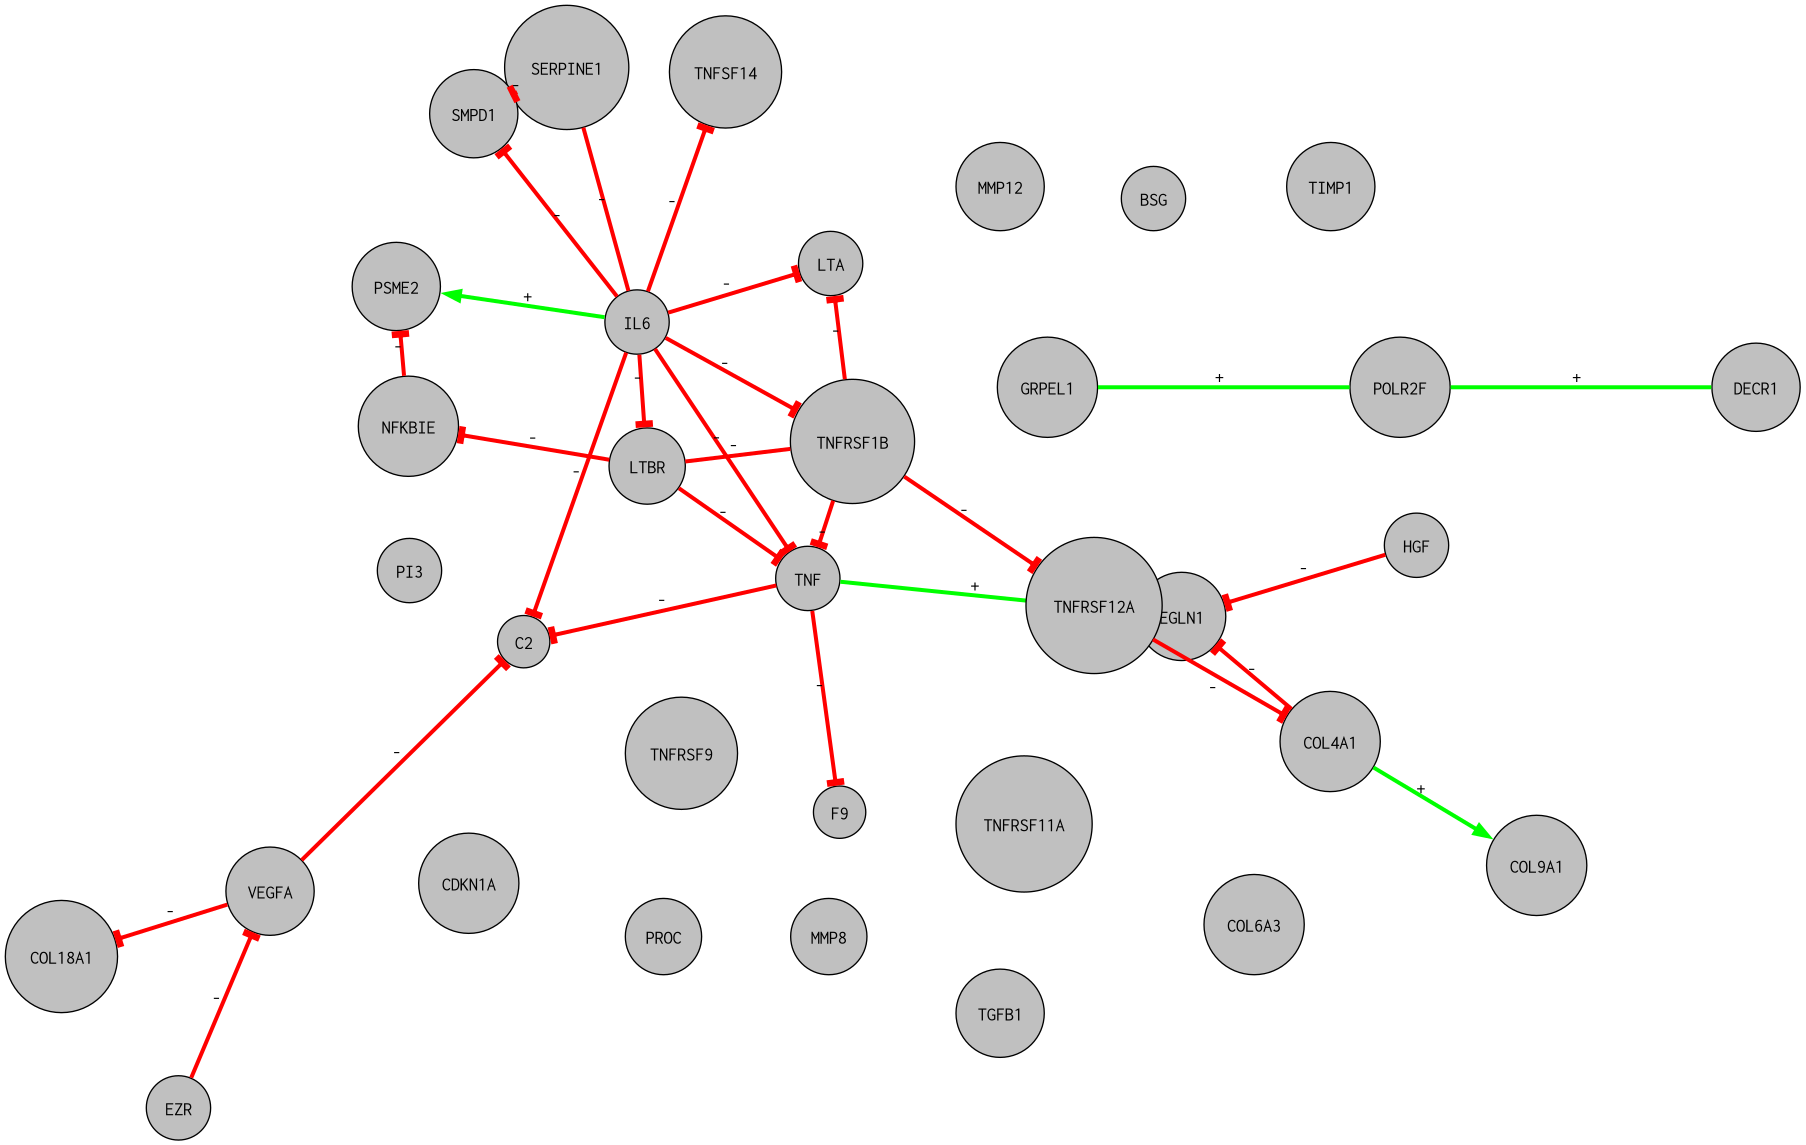

In [23]:
from IPython.display import Image
display(Image(file_folder+"/only_experiments/"+'inferred_max_criterion_solution.png', width=500))

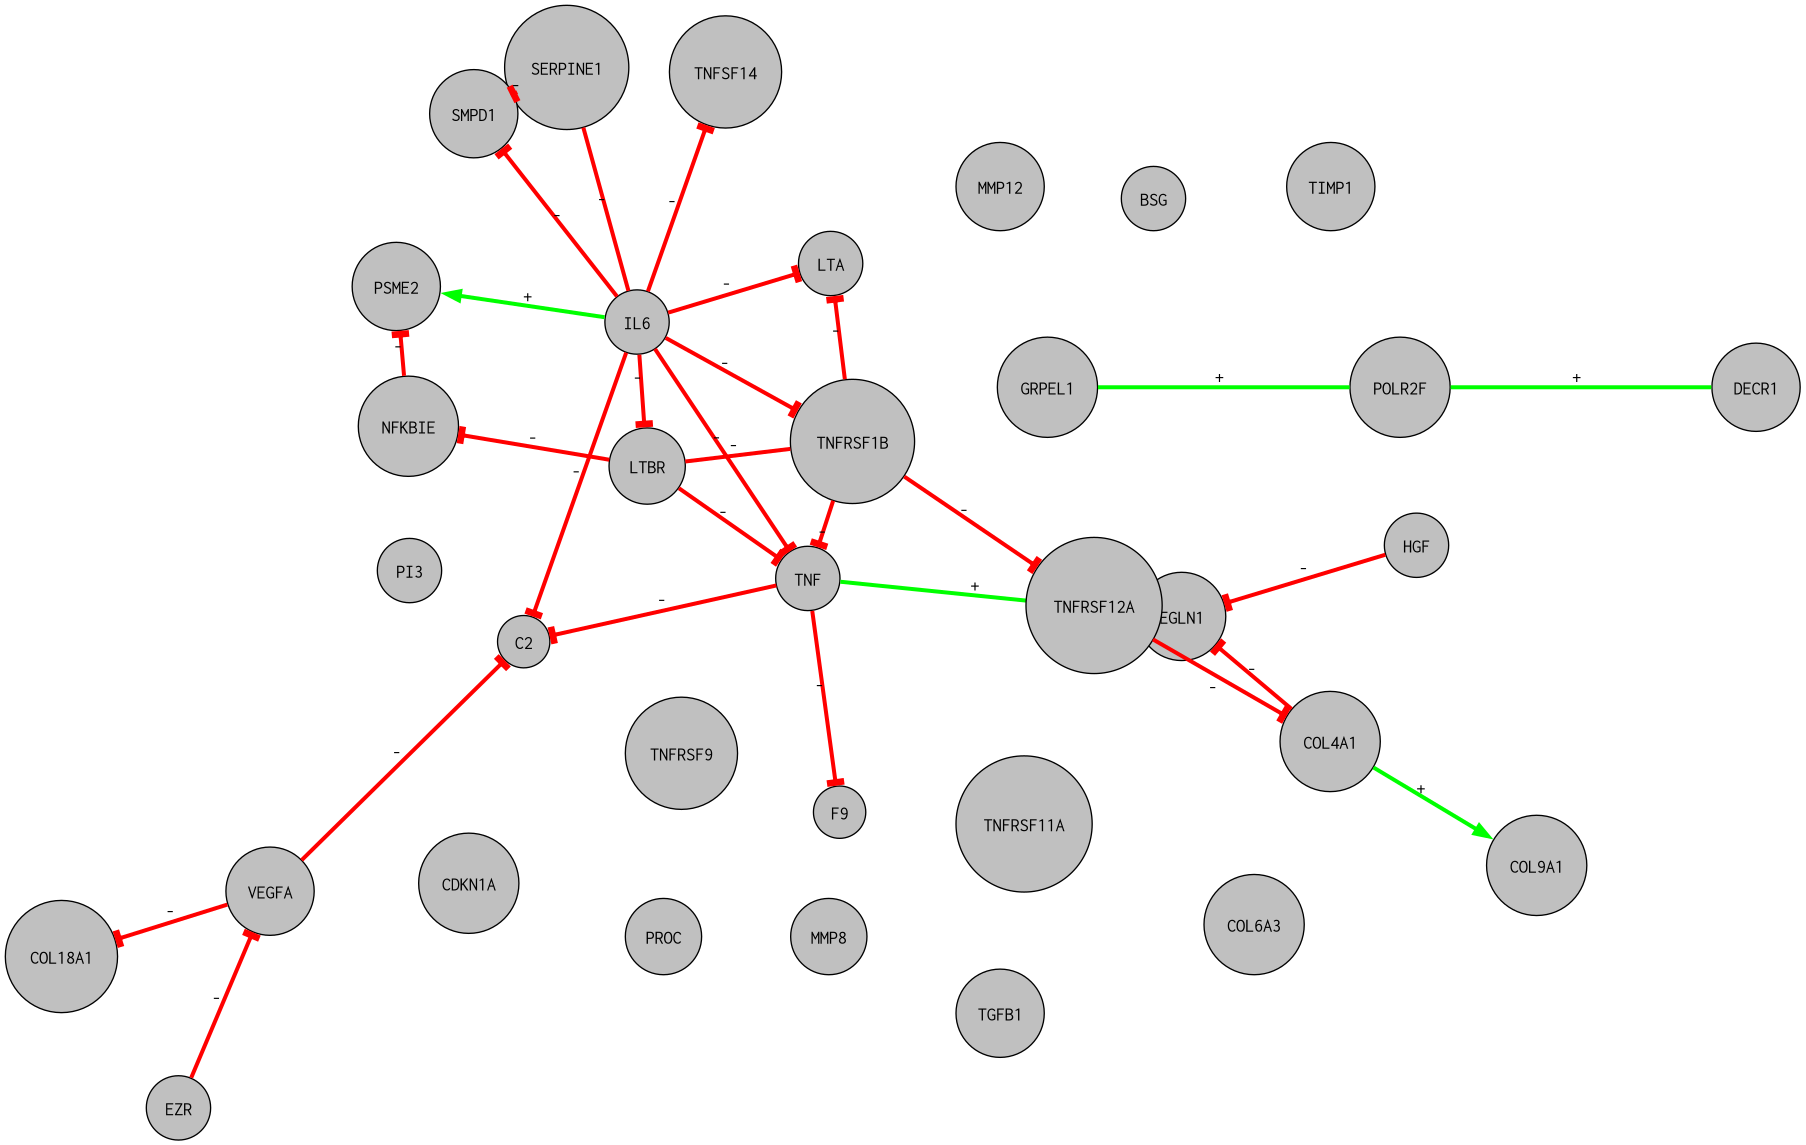

In [24]:
from IPython.display import Image
display(Image(file_folder+"/only_genes/"+'inferred_max_criterion_solution.png', width=500))

As expected (as we used the same prior knowledge network and experimental constraints), we obtain the same network as when we only used the gene list as input.